In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

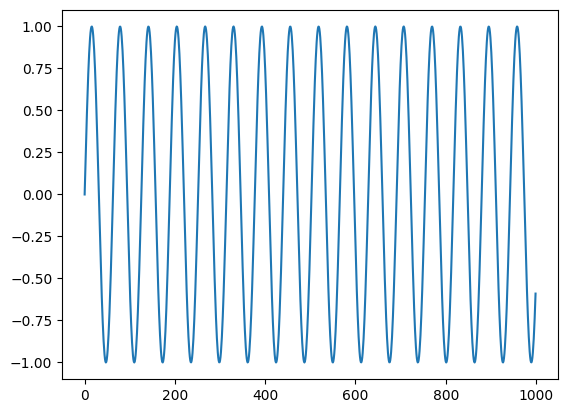

In [ ]:
# Create the original data
N = 1000
series = np.sin(0.1*np.arange(N))

# plot
plt.plot(series)
plt.show()

In [ ]:
### build the dataset
T = 10
X = []
Y = []
for t in range(len(series) - T):
    x = series[t:t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)

X = np.array(X).reshape(-1, T, 1)
Y = np.array(Y).reshape(-1, 1)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (990, 10, 1) Y.shape (990, 1)


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
### Define simple RNN
# N = number of samples
# T = sequence length
# D = number of input features
# M = number of hidden units
# K = number of output units
# L = number of layers
class simpleRNN(nn.Module):
  def __init__(self, input_size, hidden_size, rnnlayers_size, output_size):
    super().__init__()
    self.D = input_size
    self.M = hidden_size
    self.K = output_size
    self.L = rnnlayers_size
    self.rnn = nn.RNN(input_size=self.D, hidden_size=self.M, num_layers=self.L, nonlinearity='relu', batch_first=True)
    self.fc = nn.Linear(self.M, self.K)

  def forward(self, X):
    h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
    out, _ = self.rnn(X, h0)
    out = self.fc(out[:, -1, :])
    return out

In [ ]:
# Instantiate the model
model = simpleRNN(input_size=1, hidden_size=32, rnnlayers_size=2, output_size=1).to(device)
model.to(device)

simpleRNN(
  (rnn): RNN(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

In [ ]:
# Make inputs and targets, and move them to GPU
X_train = torch.from_numpy(X[:700].astype(np.float32))
y_train = torch.from_numpy(Y[:700].astype(np.float32))
X_test = torch.from_numpy(X[700:].astype(np.float32))
y_test = torch.from_numpy(Y[700:].astype(np.float32))
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [ ]:
# Set the loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [ ]:

def full_gd(model, criterion, optimizer, X_train, y_train, X_test, y_test, epochs=200):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    for i in range(epochs):
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        train_losses[i] = loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_test_pred = model(X_test)
        test_loss = criterion(y_test_pred, y_test)
        test_losses[i] = test_loss.item()

        if i % 5 == 0:
            print(f"Epoch {i+1}/{epochs}, Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}")

    return train_losses, test_losses

In [ ]:
train_losses, test_losses = full_gd(model, criterion, optimizer, X_train, y_train, X_test, y_test)

Epoch 1/200, Loss: 0.5340, Test Loss: 20.6169
Epoch 6/200, Loss: 0.5399, Test Loss: 0.5033
Epoch 11/200, Loss: 0.4620, Test Loss: 0.4236
Epoch 16/200, Loss: 0.4492, Test Loss: 0.8547
Epoch 21/200, Loss: 0.1963, Test Loss: 0.1767
Epoch 26/200, Loss: 0.0491, Test Loss: 0.0344
Epoch 31/200, Loss: 0.0416, Test Loss: 0.0465
Epoch 36/200, Loss: 0.0287, Test Loss: 0.0313
Epoch 41/200, Loss: 0.0198, Test Loss: 0.0156
Epoch 46/200, Loss: 0.0120, Test Loss: 0.0077
Epoch 51/200, Loss: 0.0063, Test Loss: 0.0134
Epoch 56/200, Loss: 0.0051, Test Loss: 0.0044
Epoch 61/200, Loss: 0.0034, Test Loss: 0.0035
Epoch 66/200, Loss: 0.0027, Test Loss: 0.0027
Epoch 71/200, Loss: 0.0024, Test Loss: 0.0022
Epoch 76/200, Loss: 0.0020, Test Loss: 0.0018
Epoch 81/200, Loss: 0.0016, Test Loss: 0.0015
Epoch 86/200, Loss: 0.0013, Test Loss: 0.0013
Epoch 91/200, Loss: 0.0011, Test Loss: 0.0012
Epoch 96/200, Loss: 0.0010, Test Loss: 0.0011
Epoch 101/200, Loss: 0.0010, Test Loss: 0.0010
Epoch 106/200, Loss: 0.0009, Test 

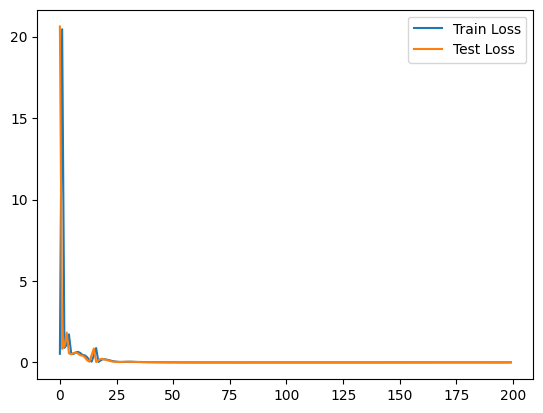

In [ ]:
# Plot the train loss and test loss
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.show()